Generating KDEs: 100%|██████████████████████████| 29/29 [00:26<00:00,  1.08it/s]


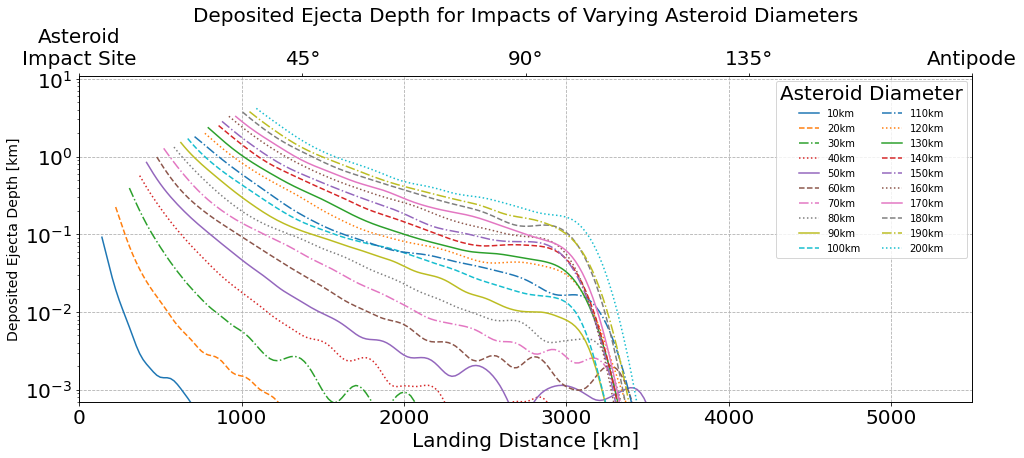

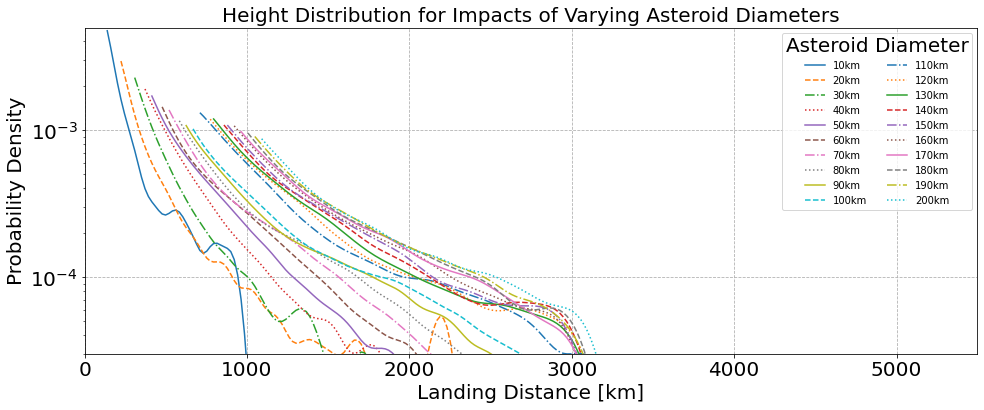

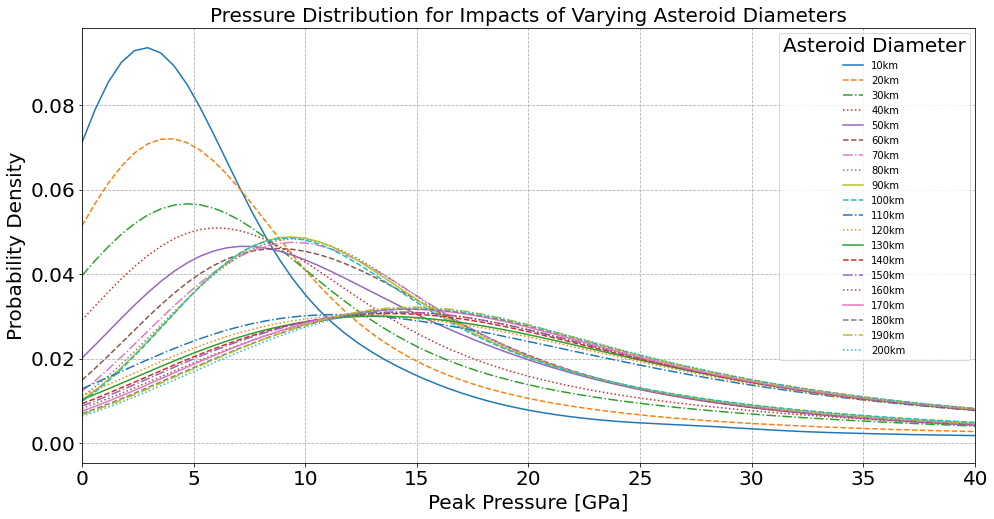

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from KDEpy import NaiveKDE, FFTKDE
import scipy.interpolate as interp
from function_library_3 import extract,trim,asteroid_diameter,scaling_law,Silverman
from tqdm import tqdm
import pickle
#================================================================================
# SETUP

#change default font size for graphs
plt.rcParams.update({'font.size':20})

# create the needed directories and clear old output
import os,glob
try:
    os.mkdir('2_KDE_Data')
except:
    for filename in glob.glob('2_KDE_Data/*'):
        os.remove(filename)    
try:
    os.mkdir('2_Ejecta_Depth')
except:
    for filename in glob.glob('2_Ejecta_Depth/*'):
        os.remove(filename)
try:
    os.mkdir('2_Basin_Pressures')
except:
    for filename in glob.glob('2_Basin_Pressures/*'):
        os.remove(filename)
try:
    os.mkdir('2_Basin_Temperatures')
except:
    for filename in glob.glob('2_Basin_Temperatures/*'):
        os.remove(filename)
        
        
line_styles = ["-","--","-.",":"]

def line_style(ls):
    return line_styles[ls % len(line_styles)]

#================================================================================
# GENERATE EJECTA DEPTH DISTRIBUTIONS AND KDEs

fig = plt.figure(figsize=[16,6],facecolor='white')  
figx = plt.figure(figsize=[16,6],facecolor='white')
axa = figx.add_subplot(111)
axb = fig.add_subplot(111)
    
fig2 = plt.figure(figsize=[16,8],facecolor='white')   
ax3 = fig2.add_subplot(111)
      
sim_list = []
size_list = []
for filename in os.listdir('0_Prime_Data'):
    if filename.endswith(".dat"):
        sim_list.append(filename)
        size_list.append(asteroid_diameter('0_Prime_Data/'+filename))
                                           
size_list, sim_list = zip(*sorted(zip(size_list, sim_list)))

R_p = 1750

Asteroid_List = []
KDE_List_x = []
Depth_List = []
KDE_List_P = []
KDE_List_T = []
KDE2D_List_ZP = []
KDE2D_List_ZT = []

x_range = [0.01*np.pi*R_p,0.99*np.pi*R_p] # don't go 180° since there will be a singularity
P_range = [0,150]
T_range = [250,3950]

XS = np.linspace(x_range[0],x_range[1],2**8)
PS = np.linspace(P_range[0],P_range[1],2**8)
TS = np.linspace(T_range[0],T_range[1],2**8)

dxdP = (XS[1]-XS[0])*(PS[1]-PS[0])
dxdT = (XS[1]-XS[0])*(TS[1]-TS[0])

scale_by = (np.linspace(0,1,len(XS)))**3

ls = 0

for sim in tqdm(sim_list, desc = 'Generating KDEs'):

    # open tracer file
    file0    = open('0_Prime_Data/{}'.format(sim),'r')
    header, data = extract(file0)
    file0.close() 
    
    R_imp = header['R_imp']
    R_c = scaling_law(2*R_imp)/2
    
    data = data[data['pressure']       > P_range[0]] ; data = data[data['pressure']       < P_range[1]]
    data = data[data['temperature']    > T_range[0]] ; data = data[data['temperature']    < T_range[1]]
    data = data[data['landing_length'] > x_range[0]] ; data = data[data['landing_length'] < x_range[1]]
    
    pressure = np.array(data['pressure'])
    temperature = np.array(data['temperature'])
    landing_length = np.array(data['landing_length'])
    volume = np.array(data['volume'])
    
    Total_Volume = np.sum(volume) # scale by the total volume of material

    # Accumulated Height (Weight must be volume for this to work)
    PDF = NaiveKDE(kernel='gaussian', bw='silverman').fit(landing_length,weights=volume).evaluate(grid_points=XS)
    PDF = PDF/np.trapz(PDF,x=XS)
    height_val = Total_Volume*PDF/(2*np.pi*R_p*np.sin(XS/R_p))
    
    Asteroid_List.append(R_imp)
    KDE_List_x.append(PDF)
    Depth_List.append(height_val)
    
    for i in range(len(XS)):
        if XS[i] > R_c:
            break
    #if (2*R_imp % 10) != 4 or R_imp > 50:
    #    axb.plot(XS[i:],height_val[i:],label=sim.replace('.dat',''))
    #    axa.plot(XS[i:],PDF[i:],label=sim.replace('.dat',''))

    #======================================================================================================
        
    # Pressures
    pressure_val = NaiveKDE(kernel='gaussian', bw='silverman').fit(pressure,weights=volume).evaluate(PS)
    pressure_val = pressure_val/np.trapz(pressure_val,x=PS)
    KDE_List_P.append(pressure_val)

    # Temperature
    temperature_val = NaiveKDE(kernel='gaussian', bw='silverman').fit(temperature,weights=volume).evaluate(TS)
    temperature_val = temperature_val/np.trapz(temperature_val,x=TS)
    KDE_List_T.append(temperature_val)
    
    if (2*R_imp % 10) != 4 or R_imp > 50:
        axb.plot(XS[i:],height_val[i:],label=sim.replace('.dat',''),ls=line_style(ls))
        axa.plot(XS[i:],PDF[i:],label=sim.replace('.dat',''),ls=line_style(ls))
        ax3.plot(PS[:],pressure_val[:],label=sim.replace('.dat',''),ls=line_style(ls))
        ls += 1
    
    #2D KDE
    h_landing = Silverman(landing_length)
    h_pressure = Silverman(pressure)
    h_temperature = Silverman(temperature) 
    
    landing_length_for_pressure = landing_length*(h_pressure/h_landing)
    landing_length_for_temperature = landing_length*(h_temperature/h_landing)
    
    grid_P = [] ; grid_T = []

    for i in range(len(XS)):
        for j in range(len(PS)):
            grid_P.append([XS[i]*(h_pressure/h_landing),PS[j]])
        
    for i in range(len(XS)):
        for j in range(len(TS)):
            grid_T.append([XS[i]*(h_temperature/h_landing),TS[j]])

    grid_P = np.array(grid_P)
    grid_T = np.array(grid_T)
    
    data0 = np.array([landing_length_for_pressure,pressure])
    land_pres=np.transpose(data0) # pressure and landing location
    data0 = np.array([landing_length_for_temperature,temperature])
    land_temp=np.transpose(data0) # temperature and landing location

    # Compute the kernel density estimate

    kdeP = FFTKDE(kernel='gaussian', bw=h_pressure)
    points_P = kdeP.fit(land_pres, weights=volume).evaluate(grid_P) 
    kdeT = FFTKDE(kernel='gaussian', bw=h_temperature)
    points_T = kdeT.fit(land_temp, weights=volume).evaluate(grid_T)
    

    # Generate the 2D grid of points and their Z values
    XP, YP = np.unique(grid_P[:, 0]), np.unique(grid_P[:, 1])
    ZP = points_P.reshape(len(XP), len(YP)).T
    XT, YT = np.unique(grid_T[:, 0]), np.unique(grid_T[:, 1])
    ZT = points_T.reshape(len(XT), len(YT)).T 
 
        
    # Generate lists of all the 2D KDE data
    
    Norm_P = np.sum(ZP)*dxdP
    Norm_T = np.sum(ZT)*dxdT
            
    KDE2D_List_ZP.append(ZP*Total_Volume/Norm_P)
    KDE2D_List_ZT.append(ZT*Total_Volume/Norm_T)
    
###################
    
ax3.set_title("Pressure Distribution for Impacts of Varying Asteroid Diameters", fontsize=20)

ax3.set_xlim(0,40)
#ax3.set_ylim(bottom=7e-4,top=11)

#ax3.set_yscale('log')
ax3.set_xlabel('Peak Pressure [GPa]')
ax3.set_ylabel('Probability Density')

ax3.grid(True, ls='--', zorder=-15); ax3.legend(title='Asteroid Diameter',fontsize=10);

fig2.savefig('Pressure Distribution All Sims.png')

##################

axb.set_title("Deposited Ejecta Depth for Impacts of Varying Asteroid Diameters", fontsize=20)
#axa.set_title("Probability Density of Landing Distance for Impacts of Varying Asteroid Diameters", fontsize=20)
axa.set_title("Height Distribution for Impacts of Varying Asteroid Diameters", fontsize=20)


axb.set_xlim(0,np.pi*R_p)
axa.set_xlim(0,np.pi*R_p)
axb.set_ylim(bottom=7e-4,top=11)
axa.set_ylim(bottom=3e-5)

axa.set_yscale('log')
axa.set_xlabel('Landing Distance [km]')
axb.set_yscale('log')
axb.set_xlabel('Landing Distance [km]')
axb.set_ylabel('Deposited Ejecta Depth [km]',fontsize=14)
axa.set_ylabel('Probability Density')

axa.grid(True, ls='--', zorder=-15); axa.legend(title='Asteroid Diameter',fontsize=10,ncol=2);
axb.grid(True, ls='--', zorder=-15); axb.legend(title='Asteroid Diameter',fontsize=10,ncol=2);

ax2 = axb.twiny()
ax2.set_xticks([0,R_p*np.pi/4,R_p*np.pi/2,3*R_p*np.pi/4, R_p*np.pi] , ['Asteroid\nImpact Site','45°','90°','135°','Antipode'])
fig.savefig('Deposited Ejecta Depth All Sims.png')


In [4]:
#================================================================================
# CREATE FUNCTION THAT EXTRACTS DATA FROM EACH BASIN

def data_extract(each):
    
    basin = each[0]
    R_c = each[3]/2
    R_imp = scaling_law(2*R_c,inverse=True)/2
    
    # open tracer file
    file0    = open('1_Basin_Data/{}.dat'.format(each[0]),'r')
    header, data = extract(file0)
    file0.close() 
    
    data = data[data['pressure']       > P_range[0]] ; data = data[data['pressure']       < P_range[1]]
    data = data[data['temperature']    > T_range[0]] ; data = data[data['temperature']    < T_range[1]]
    data = data[data['landing_length'] > x_range[0]] ; data = data[data['landing_length'] < x_range[1]]
    
    pressure = np.array(data['pressure'])
    temperature = np.array(data['temperature'])
    landing_length = np.array(data['landing_length'])
    volume = np.array(data['volume'])
    
    
    if R_imp <= Asteroid_List[0]:
        height_val      = Depth_List[0]
        landing_val     = KDE_List_x[0]
        pressure_val    = KDE_List_P[0]
        temperature_val = KDE_List_T[0]
        ZP = KDE2D_List_ZP[0]
        ZT = KDE2D_List_ZT[0]
                    
    elif R_imp >= Asteroid_List[-1]:
        height_val      = Depth_List[-1]
        landing_val     = KDE_List_x[-1]
        pressure_val    = KDE_List_P[-1]
        temperature_val = KDE_List_T[-1]
        ZP = KDE2D_List_ZP[-1]
        ZT = KDE2D_List_ZT[-1]
        
    else:
        for i in range(len(Asteroid_List)):
            if Asteroid_List[i] < R_imp < Asteroid_List[i+1]:
                                
                lower_ratio = (R_imp - Asteroid_List[i])/(Asteroid_List[i+1]-Asteroid_List[i])
                upper_ratio = (Asteroid_List[i+1] - R_imp)/(Asteroid_List[i+1]-Asteroid_List[i])
                
                height_val      = lower_ratio*np.array(Depth_List[i+1]) + upper_ratio*np.array(Depth_List[i])
                landing_val     = lower_ratio*np.array(KDE_List_x[i+1]) + upper_ratio*np.array(KDE_List_x[i])
                pressure_val    = lower_ratio*np.array(KDE_List_P[i+1]) + upper_ratio*np.array(KDE_List_P[i])
                temperature_val = lower_ratio*np.array(KDE_List_T[i+1]) + upper_ratio*np.array(KDE_List_T[i])
                ZP = lower_ratio*np.array(KDE2D_List_ZP[i+1]) + upper_ratio*np.array(KDE2D_List_ZP[i])
                ZT = lower_ratio*np.array(KDE2D_List_ZT[i+1]) + upper_ratio*np.array(KDE2D_List_ZT[i])
                
                break     
    
    #-----------------------------------------------
    #            Graph the Basin Data
    #-----------------------------------------------
    
    # Landing Length Histogram
    fig = plt.figure(figsize=[16,8],facecolor='white')
    plt.suptitle("{}".format(basin), fontsize=32)
    plt.title('Landing Length Distribition')
    plt.hist(landing_length, bins = 500, alpha=.2, weights=volume, density=True)
    plt.plot(XS,landing_val, label='KDE')
    plt.xlabel('Landing Length [km]')
    plt.ylabel('Probability Density')
    plt.xlim(x_range[0],x_range[1])
    plt.yscale('log')
    plt.grid(True, ls='--', zorder=-15); plt.legend(); 
    fig.savefig('2_Ejecta_Depth/Landing Length Distribution of {}'.format(basin))
    plt.close(fig)
    
    # Ejecta Depth
    fig = plt.figure(figsize=[16,8],facecolor='white')
    plt.suptitle("{}".format(basin), fontsize=32)
    plt.title('Deposited Ejecta Depth from Asteroid Impact Site to Antipode')
    plt.plot(XS,height_val,label='Deposited Ejecta Depth')
    plt.xlabel('\nLanding Distance')
    plt.xlim(x_range[0],x_range[1])
    plt.ylabel('Height [km]')
    plt.ylim(bottom=5e-7)
    plt.yscale('log') 
    plt.grid(True, ls='--', zorder=-15); plt.legend();
    fig.savefig('2_Ejecta_Depth/Deposited Ejecta Depth of {}'.format(basin))
    plt.close(fig)   
    
    #-----------------------------------------------
    
    # Pressure Histogram
    fig = plt.figure(figsize=[16,8],facecolor='white')
    plt.suptitle("{}".format(basin), fontsize=32)
    plt.title('Peak Pressure Distribition')
    plt.hist(pressure, bins = 500, alpha=.2, weights=volume, density=True)
    plt.plot(PS,pressure_val, label='KDE')
    plt.xlabel('Pressure [GPa]')
    plt.ylabel('Probability Density')
    plt.xlim(P_range[0],P_range[1])
    plt.grid(True, ls='--', zorder=-15); plt.legend(); 
    fig.savefig('2_Basin_Pressures/Pressure Distribution of {}'.format(basin))
    plt.close(fig)
    
    # Temperature Histogram
    fig = plt.figure(figsize=[16,8],facecolor='white')
    plt.suptitle("{}".format(basin), fontsize=32)
    plt.title('Peak Temperature Distribition')
    plt.hist(temperature, bins = 500, alpha=.2, weights=volume, density=True)
    plt.plot(TS,temperature_val, label='KDE')
    plt.xlabel('Temperature [K]')
    plt.ylabel('Probability Density')
    plt.xlim(T_range[0],T_range[1])
    plt.grid(True, ls='--', zorder=-15); plt.legend(); 
    fig.savefig('2_Basin_Temperatures/Temperature Distribution of {}'.format(basin))
    plt.close(fig)
    
    #-----------------------------------------------
    # (  These graphs can be very slow if grid_points are set sufficiently high (> 2**7)  )
    
    # Pressure 2D KDE
    fig = plt.figure(figsize=[16,10],facecolor='white')
    ax1 = fig.add_subplot(111)
    plt.suptitle("Peak Pressure vs Landing Distance of {}".format(basin), fontsize=32)
    im = ax1.pcolormesh(XS, YP, np.log10(ZP), cmap="viridis",shading='auto',vmin=-1)
    ax1.set_xlabel('\nLanding Distance [km]') 
    ax1.set_xlim(x_range[0],x_range[1])
    #ax1.set_xscale('log') 
    ax1.set_ylabel('Pressure [GPa]')
    ax1.set_ylim(P_range[0],P_range[1])
    cbar = plt.colorbar(im, label='Log10 of Volume Density\nLog10[km^3/(km GPa)]')
    #ax1.scatter(landing_length, pressure, c='white', s=10)
    ax2 = ax1.twiny()
    ax2.set_xticks([0,R_p*np.pi/4,R_p*np.pi/2,3*R_p*np.pi/4, R_p*np.pi] , ['Asteroid\nImpact Site','45°','90°','135°','Antipode'])
    fig.savefig('2_Basin_Pressures/Pressure 2D KDE of {}'.format(basin))
    plt.close(fig)
    
    # Temperature 2D KDE
    fig = plt.figure(figsize=[16,10],facecolor='white')
    ax1 = fig.add_subplot(111)
    plt.suptitle("Peak Temperature vs Landing Distance of {}".format(basin), fontsize=32)
    im = ax1.pcolormesh(XS, YT, np.log10(ZT), cmap="viridis",shading='auto',vmin=-2)
    ax1.set_xlabel('\nLanding Distance [km]') 
    ax1.set_xlim(x_range[0],x_range[1])
    ax1.set_ylabel('Temperature [K]')
    ax1.set_ylim(T_range[0],T_range[1])
    cbar = plt.colorbar(im, label='Log10 Volume Density\nLog10[km^3/(km K)]')
    #ax1.scatter(landing_length, temperature, c='white', s=10)
    ax2 = ax1.twiny()
    ax2.set_xticks([0,R_p*np.pi/4,R_p*np.pi/2,3*R_p*np.pi/4, R_p*np.pi] , ['Asteroid\nImpact Site','45°','90°','135°','Antipode'])
    fig.savefig('2_Basin_Temperatures/Temperature 2D KDE of {}'.format(basin))
    plt.close(fig)
    
    return [basin, XS, PS, TS, ZP, ZT, height_val]

    
#================================================================================
# CREATE MAIN FUNCTION 

# Open the user input file with the information from each basin
input_file = open('Basins.txt','r')
basins = []
basin_order = []
impact_order = []
line = 1,' '
while line[0:3] != 'END':
    line = input_file.readline()
    if line[0:1] == 'B':
        basins.append(trim(line.split(':'))) 
            
# make output files for each basin
for each in tqdm(basins, desc = 'Interpolating Data'):
    KDEfile = open('2_KDE_Data/{}.dat'.format(each[0]),'wb')
    pickle.dump(data_extract(each),KDEfile)
    KDEfile.close()   

print('COMPLETED')

Interpolating Data: 100%|███████████████████████| 30/30 [00:44<00:00,  1.49s/it]

COMPLETED
